# House Price Prediction with Neural Network

## Overview
This report shows a neural network model implemented with PyTorch to predict housing prices using the Housing.csv dataset. Steps include data preprocessing (encoding, scaling, outlier handling), model training with regularization (dropout, weight decay), and evaluation. Results (MSE, R², sample predictions) provide insight into model performance, which can be further analyzed or improved.

## Dataset Description

This dataset contains **545 housing records** with various attributes relevant to real estate pricing. It presents a typical regression task involving a mix of numerical and categorical features. Each row represents a unique property.

### Features Overview

| Column Name        | Description |
|--------------------|-------------|
| `price`            | (Target) The price of the house. Values range in millions. |
| `area`             | Total area of the house in square feet. |
| `bedrooms`         | Number of bedrooms. |
| `bathrooms`        | Number of bathrooms. |
| `stories`          | Number of floors (stories) in the house. |
| `mainroad`         | Whether the house is located on a main road (`yes` / `no`). |
| `guestroom`        | Availability of a guest room (`yes` / `no`). |
| `basement`         | Whether the house has a basement (`yes` / `no`). |
| `hotwaterheating`  | Availability of hot water heating (`yes` / `no`). |
| `airconditioning`  | Presence of air conditioning (`yes` / `no`). |
| `parking`          | Number of parking spaces. |
| `prefarea`         | Whether the house is in a preferred locality (`yes` / `no`). |
| `furnishingstatus` | Type of furnishing: `furnished`, `semi-furnished`, or `unfurnished`. |



In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Neural Network Architecture
- Input layer: Size determined by input_size (number of features)
- Hidden layer 1: 256 neurons with ReLU activation and 50% dropout
- Hidden layer 2: 128 neurons with ReLU activation and 30% dropout
- Output layer: 1 neuron (for regression output)
- Forward Pass: Data flows through fully connected layers (fc1, fc2, fc3), with ReLU activations adding non-linearity and dropout preventing overfitting

In [ ]:
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#Data preprocessing
load_and_preprocess_data() function performs following steps:

- Loading the Dataset from the csv file.

- Binary Encoding: Six categorical columns with "yes"/"no" values are converted into binary: `'yes' → 1, 'no' → 0`.

- One-Hot Encoding: The furnishingstatus column, which has more than two categories, is encoded using dummy variables with `drop_first=True` to avoid multicollinearity. This transforms the single column into two separate binary features.

- Outlier Handling: To reduce the effect of extreme values in the price, the upper end of the distribution is capped at the 95th percentile.

- Target Transformation: The target variable is log-transformed using `np.log1p()` to reduce skewness and stabilize variance.

- Train-Test Split: The data is split into training and testing sets with an 80-20 ratio using `train_test_split()`.

- Feature Scaling: All features and the target variable are standardized using `StandardScaler` to have zero mean and unit variance.

- NumPy arrays are converted to PyTorch tensors,

- The function returns the scaled training and testing features/targets as tensors, along with the fitted scaler_y object to later inverse-transform predictions back to the original price scale.

In [ ]:
def load_and_preprocess_data(filepath='Housing.csv'):
    data = pd.read_csv(filepath)

    # Binary conversion
    binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
    data[binary_features] = data[binary_features].apply(lambda x: x.map({'yes': 1, 'no': 0}))

    # One-hot encode
    data = pd.get_dummies(data, columns=['furnishingstatus'], prefix='furnish', drop_first=True).astype(int)

    # Cap price
    price_cap = data['price'].quantile(0.95)
    data['price'] = data['price'].clip(upper=price_cap)

    # Features & target
    X = data.drop('price', axis=1)
    y = np.log1p(data['price'].values)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train, X_test, y_train, y_test, scaler_y


## Model Training Function train_model()

this function handles all aspects of training, validation, learning rate adjustment, and early stopping. Below is a breakdown of its key components:

### Parameters
- **`model`**: An instance of a PyTorch neural network for regression.
- **`X_train`, `y_train`**: Training data and corresponding target values (log-transformed & scaled)
- **`X_test`, `y_test`**: Validation data and targets for evaluating generalization during training
- **`optimizer`**: Optimizer used for gradient descent
- **`criterion`**: Loss function to optimize, MSE
- **`scheduler`**: Learning rate scheduler that reduces LR on plateau of validation loss
- **`num_epochs`**: Maximum number of training epochs.
- **`patience`**: Number of epochs to wait for improvement before early stopping.

### Key Features
- Evaluation on validation set
- Learning rate scheduling
- Early stopping
- Model checkpointing

### Outputs
- Returns three lists:
  - `train_losses`: MSE loss values on the train set per epoch
  - `test_losses`: MSE loss values on the test set per epoch
  - `model`: The best-performing model (reloaded from saved checkpoint if exists).

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, patience=20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

    best_test_loss = float('inf')
    patience_counter = 0
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_loss = criterion(y_pred_train, y_train)
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        scheduler.step(test_loss)

        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    return train_losses, test_losses

## Model Evaluation Function evaluate_model()

This function helps quantify how well the trained model generalizes to unseen data, using meaningful price values. It performs the **final evaluation** of the trained regression model on the **test dataset**.


### Parameters
- **`model`**: The trained PyTorch model (`RegressionNet`).
- **`X_test`, `y_test`**: Scaled test feature set and target values (log-transformed & standardized).
- **`scaler_y`**: Scikit-learn scaler used to reverse standardization of target predictions.

### Functionality
- **Switches model to evaluation mode** with `model.eval()` and disables gradient tracking with `torch.no_grad()`.
- **Predicts scaled log-targets**, then reverses standardization using `scaler_y.inverse_transform()`.
- **Applies exponential transform** to return predictions to the original price scale using `np.expm1()`.
- Computes:
  - **Mean Squared Error (MSE)** on the original price scale
  - **R² Score** as a measure of explained variance

### Outputs
- Prints:
  - Test MSE
  - R² score
  - Few sample predictions vs. actual prices
- Returns:
  - `y_pred_original`: Final predicted prices (actual scale)
  - `y_test_original`: Ground truth prices (actual scale)



In [ ]:
def evaluate_model(model, X_test, y_test, scaler_y):
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = nn.MSELoss()(y_pred, y_test)
        y_pred_scaled = scaler_y.inverse_transform(y_pred.numpy())
        y_test_scaled = scaler_y.inverse_transform(y_test.numpy())
        y_pred_original = np.expm1(y_pred_scaled)
        y_test_original = np.expm1(y_test_scaled)
        mse = mean_squared_error(y_test_original, y_pred_original)
        r2 = r2_score(y_test_original, y_pred_original)
        print(f'Test MSE (original scale): {mse:.4f}')
        print(f'R2 Score: {r2:.4f}')
        return y_pred_original, y_test_original

## Training and Validation Loss Curve: plot_loss_curves()

This function visualizes the **training** and **test** loss values over epochs.
- Plots the training and test loss curves side-by-side.
- Highlights overfitting or underfitting trends based on divergence between the two curves.
- Shows how well the model improves over time.



In [ ]:
def plot_loss_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(test_losses, label="Test Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Prediction Quality Visualization: plot_results()

This function provides two diagnostic plots to visualize prediction quality:

1. **Predicted vs Actual Scatter Plot**
   - Each point compares a predicted value to the actual.
   - A red dashed line represents perfect predictions (y = x).
   - The closer the points are to this line, the better.

2. **Residual Plot**
   - Shows the difference between actual and predicted prices.
   - A horizontal line at zero indicates perfect prediction.
   - Helps detect bias or non-random patterns in errors.

In [ ]:
def plot_results(y_pred_original, y_test_original):
    plt.figure(figsize=(12, 5))

    # Predicted vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()],
             'r--', lw=2)
    plt.xlabel('Actual Price (Millions)')
    plt.ylabel('Predicted Price (Millions)')
    plt.title('Predicted vs Actual Prices')

    # Residual plot
    residuals = y_test_original - y_pred_original
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_original, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Price (Millions)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    plt.tight_layout()
    plt.show()

Epoch [25/100], Train Loss: 0.3085, Test Loss: 0.5639, LR: 0.001000
Early stopping triggered at epoch 31
Test MSE (original scale): 1063002898432.0000
R2 Score: 0.7042

Sample predictions:
Predicted: [4124840.8 6843386.  3258806.8 4612546.  3132251.8]
Actual   : [4060000.5 6650002.  3710001.2 6440002.  2799999. ]


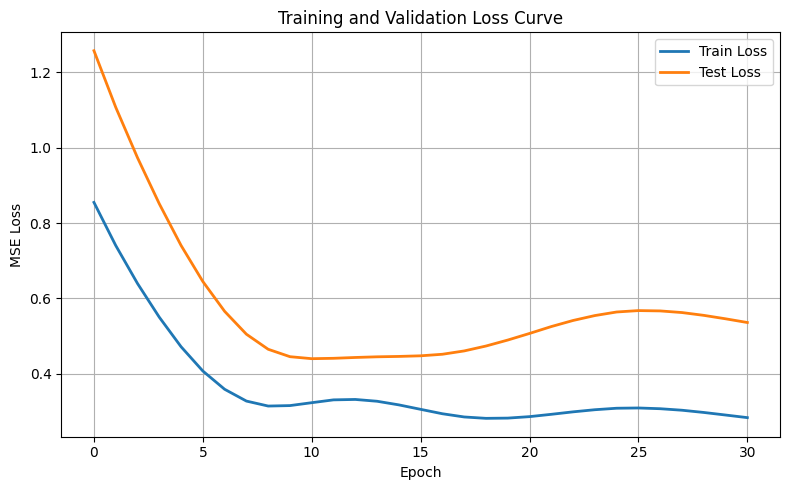

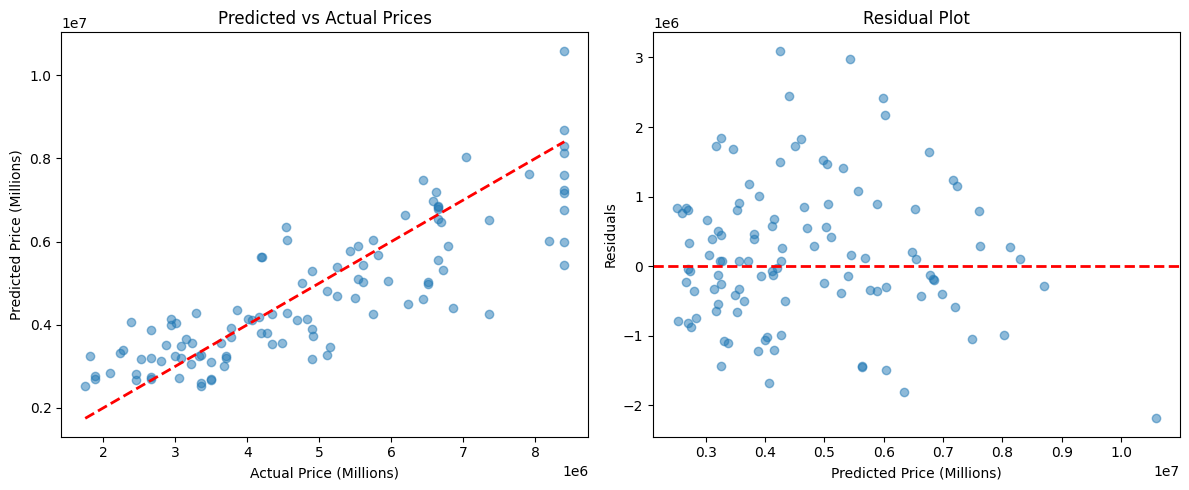

In [ ]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test, scaler_y = load_and_preprocess_data()
    input_size = X_train.shape[1]
    model = RegressionNet(input_size)

    train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)
    y_pred_original, y_test_original = evaluate_model(model, X_test, y_test, scaler_y)

    print("\nSample predictions:")
    print("Predicted:", y_pred_original[:5].flatten())
    print("Actual   :", y_test_original[:5].flatten())

    plot_loss_curves(train_losses, test_losses)
    plot_results(y_pred_original, y_test_original)

## Conclusion

In this project was developed a regression model using a fully connected neural network to predict house prices based on various features such as area, number of rooms, furnishing status, and binary categorical variables. After preprocessing the data, the model was trained using PyTorch with techniques like:

- **Dropout regularization** to prevent overfitting
- **Learning rate scheduling** to adapt during training
- **Early stopping** to avoid unnecessary computation and model degradation

The model achieved an **R² = 0.7**, indicating it explains around **70%** of the variance in the housing prices on unseen data.

Visual diagnostics such as the **loss curves**, **predicted vs actual scatter plot**, and **residuals** confirmed that the model has not excellent, but reasonable generalization without severe overfitting (Train Loss: 0.3085, Test Loss: 0.5639).

Overall, the pipeline successfully demonstrates how deep learning can be applied to structured data for regression tasks, given proper preprocessing and training strategies.